In [53]:
import os
import sys
from chordUtils import json2lab
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp
from sklearn.model_selection import KFold


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [54]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [55]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = KFold(n_splits = nfolds, shuffle = True, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(chromas):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(kinds, chromas, ncomp, nfolds=5)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

# No normalization

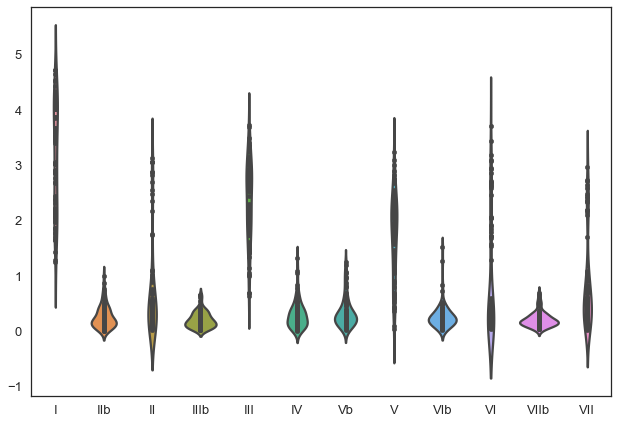

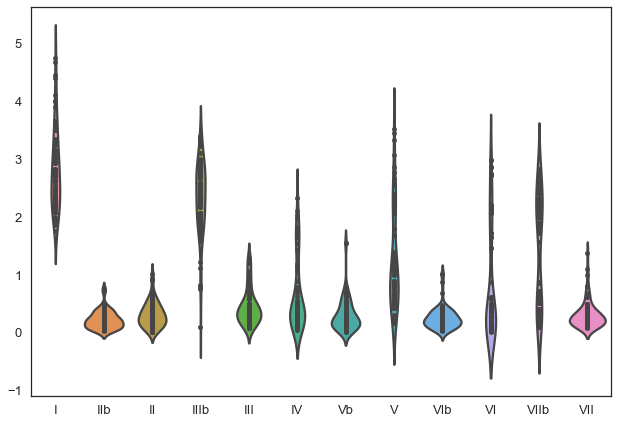

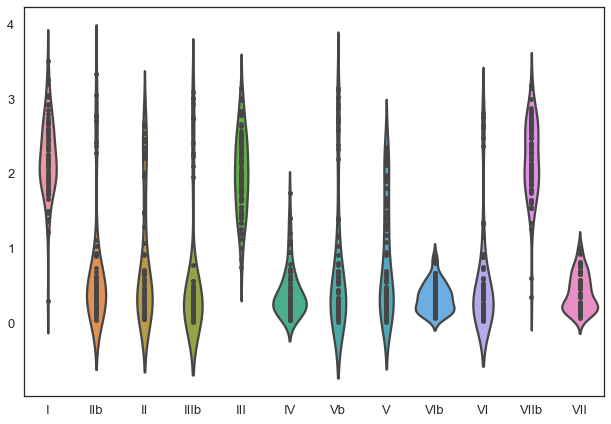

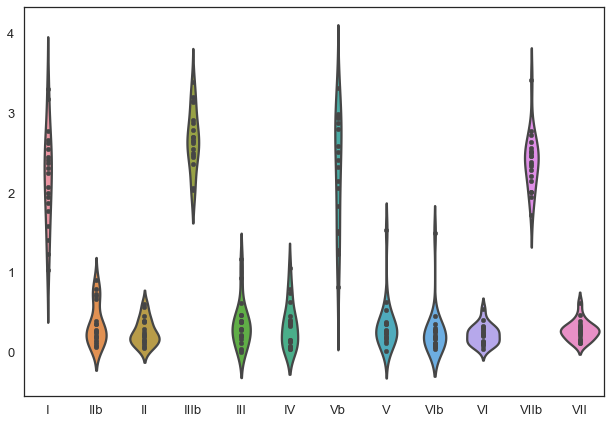

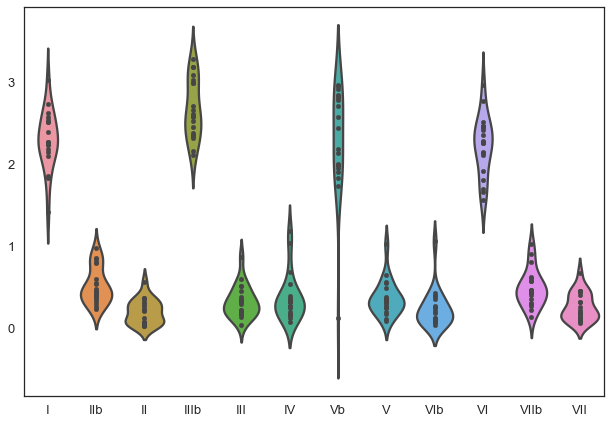

maj 100.0 %
min 97.6470588235 %
dom 97.4025974026 %
hdim7 100.0 %
dim 100.0 %
total:  98.615916955 %
maj 100.0 %
min 97.6470588235 %
dom 100.0 %
hdim7 100.0 %
dim 100.0 %
total:  99.3079584775 %
maj BIC:  -95.7534576752  N:  11
min BIC:  -781.168448091  N:  11
dom BIC:  -259.515074029  N:  11
hdim7 BIC:  -412.133254896  N:  5
dim BIC:  -542.644573681  N:  3


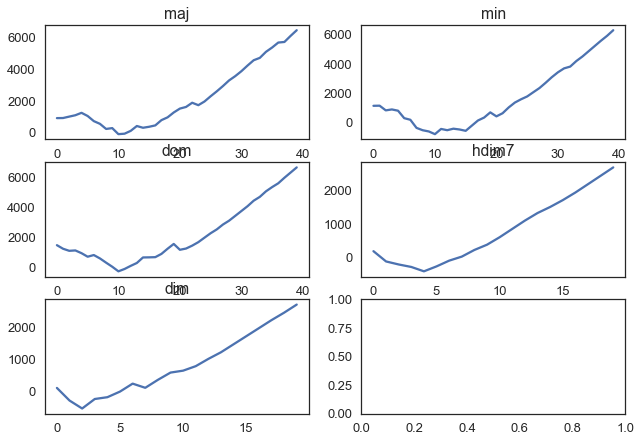

[ 11.  11.  11.   5.   3.]
[  99.22115241  100.          100.          100.          100.        ]
[ 90.64125832  83.04900181  76.45493043  71.9600726   67.79794313]


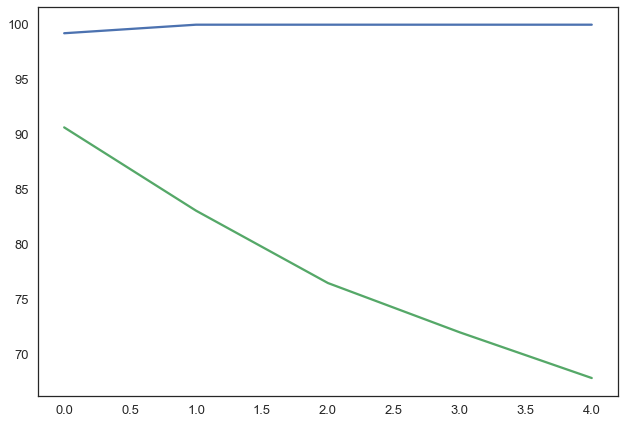

In [56]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
model = fitConstModel(kinds, chromas, [3,2,2,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas)
print n_components

trains, tests = trainTestSymmetricalModels(kinds, chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()


# Just L1

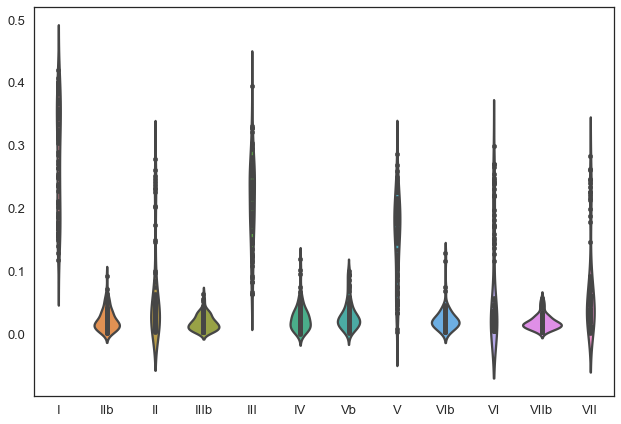

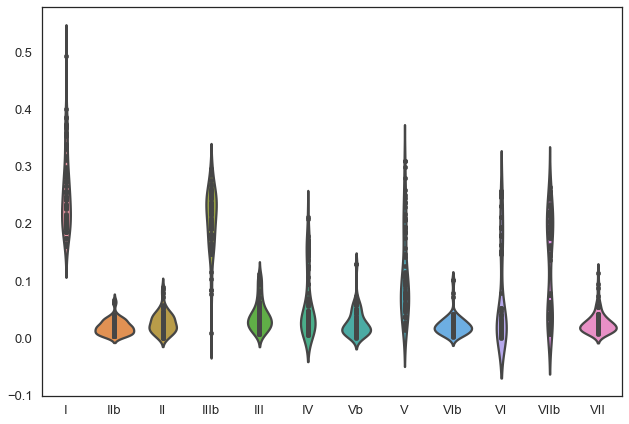

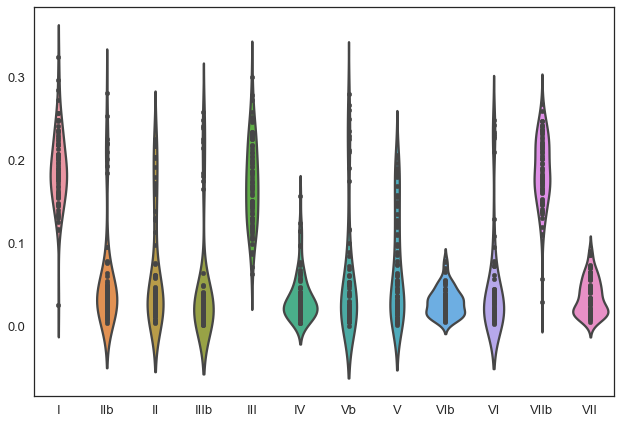

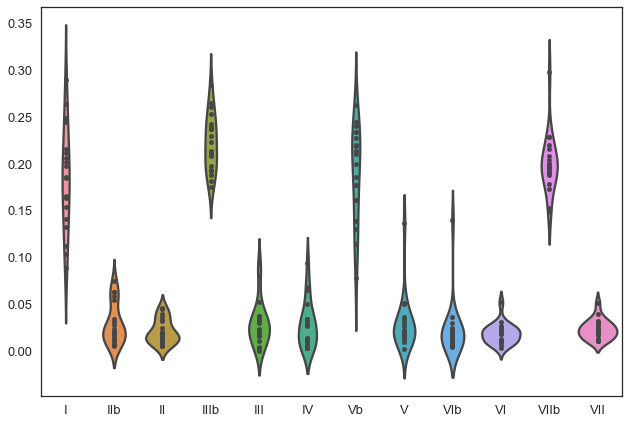

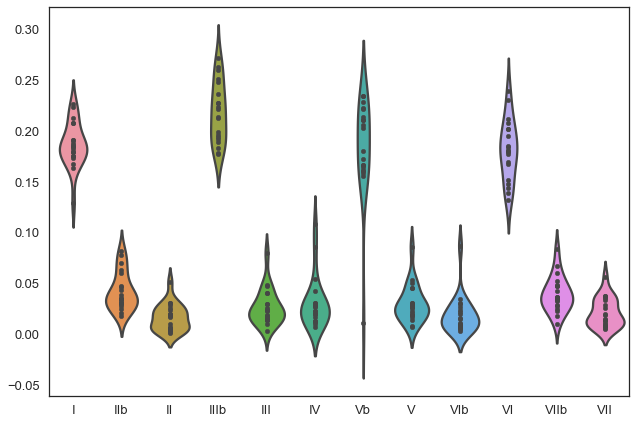

maj BIC:  -4669.57911337  N:  1
min BIC:  -4315.36489802  N:  1
dom BIC:  -3572.80970291  N:  2
hdim7 BIC:  -1155.42261212  N:  2
dim BIC:  -1238.46538884  N:  2


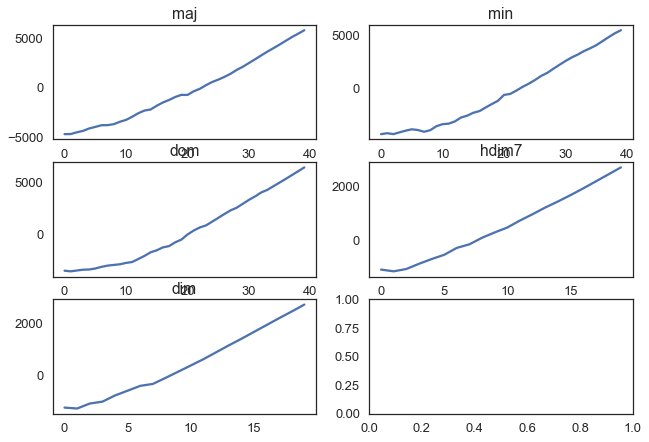

[ 1.  1.  2.  2.  2.]
[  98.87483206   99.91341991   99.74063293  100.          100.        ]
[ 92.02661827  84.76709014  79.91530551  76.11615245  73.33938294]


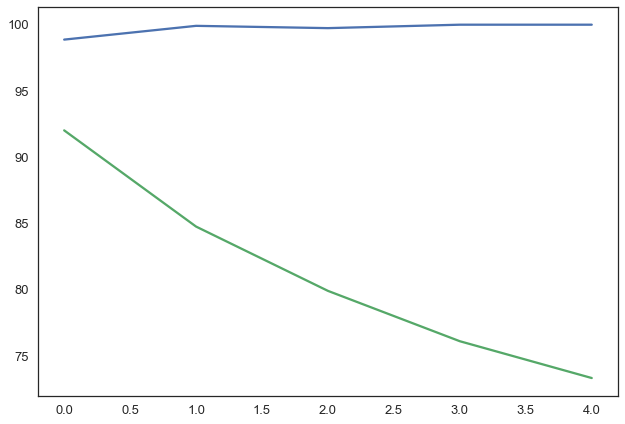

In [57]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l1Chromas = normalize(chromas)
violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [2,7,2,1,1])
score(model, kinds, l1Chromas)
n_components = findOptimalNComponentsByBIC(l1Chromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l1Chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()


# Just L2

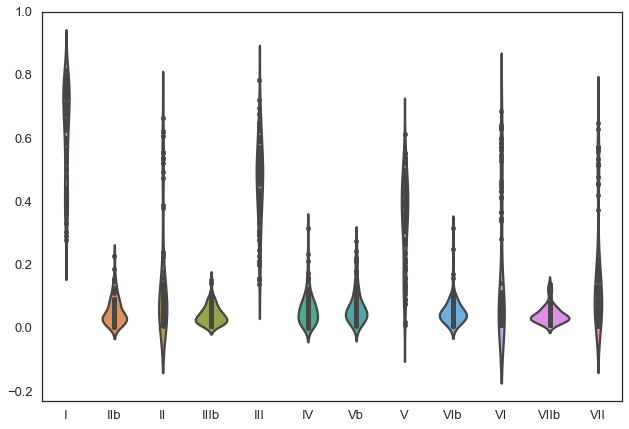

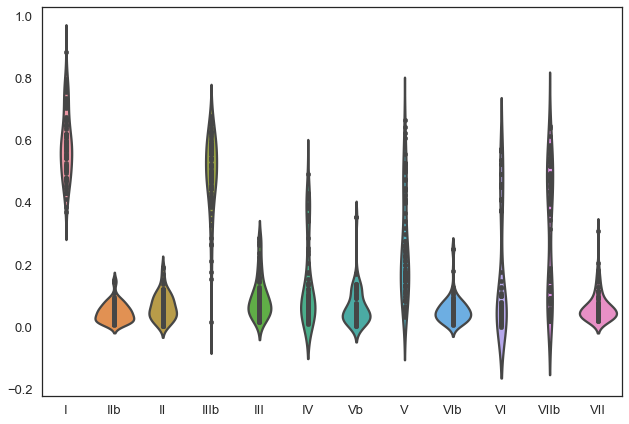

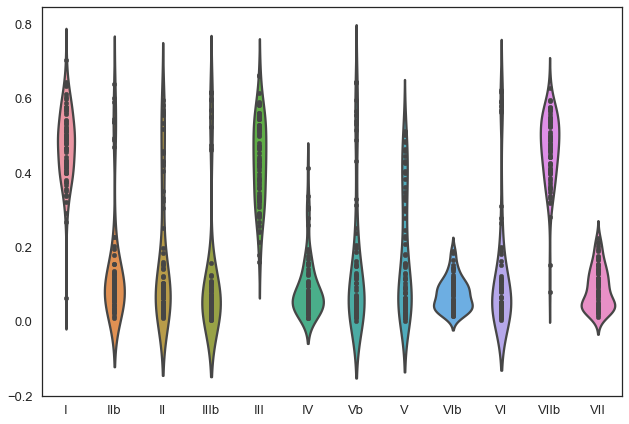

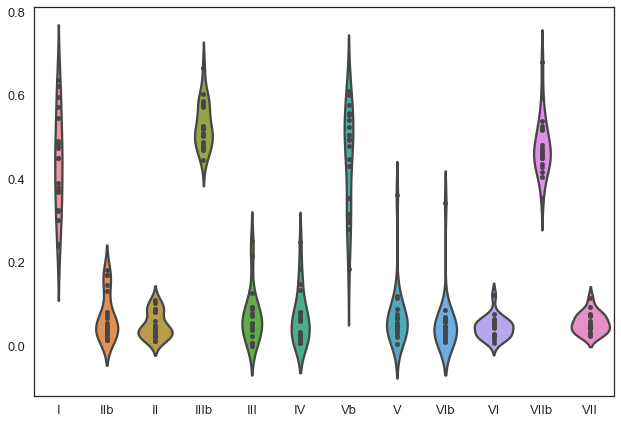

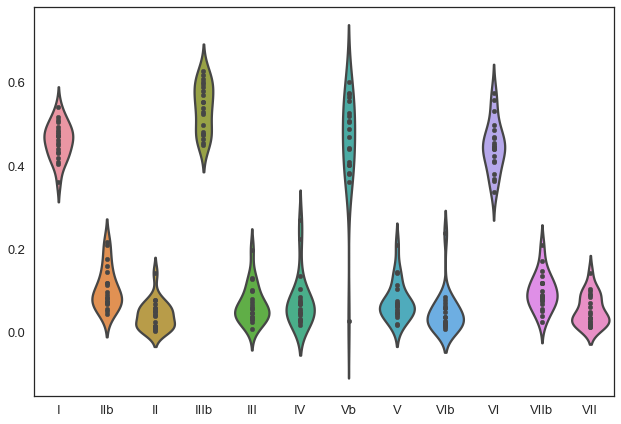

maj BIC:  -2517.37883241  N:  2
min BIC:  -2501.5500256  N:  7
dom BIC:  -1858.40836125  N:  10
hdim7 BIC:  -790.465602354  N:  2
dim BIC:  -910.932980813  N:  2


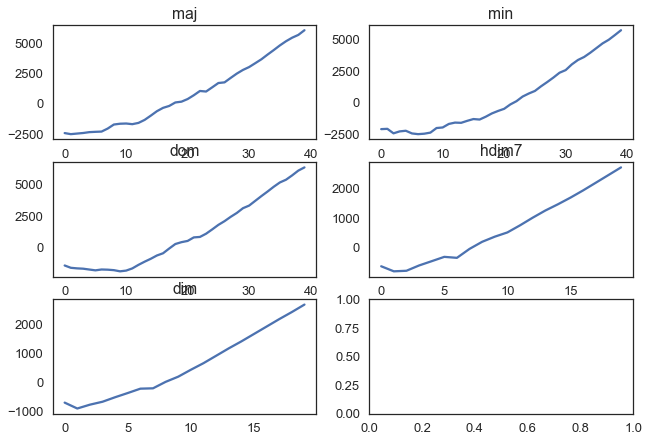

[  2.   7.  10.   2.   2.]
[  99.13419913   99.91341991   99.82683983   99.91341991  100.        ]
[ 92.36539625  83.36963097  75.40834846  71.61524501  67.46521476]


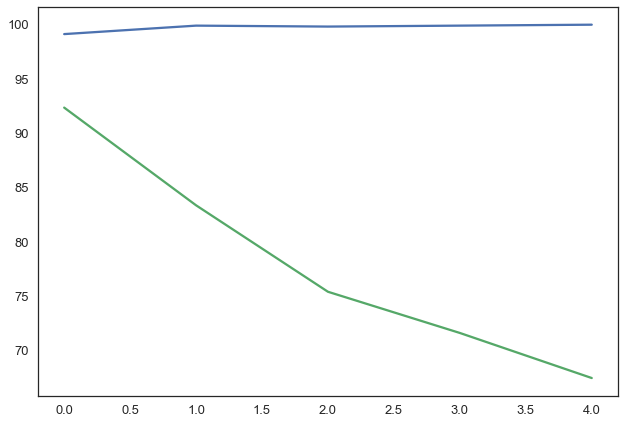

In [58]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l2Chromas = normalize(chromas, norm='l2')
violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
score(model, kinds, l2Chromas)
n_components = findOptimalNComponentsByBIC(l2Chromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l2Chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Just Max

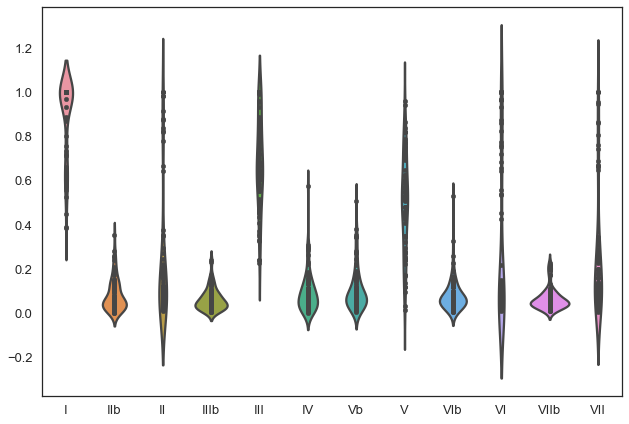

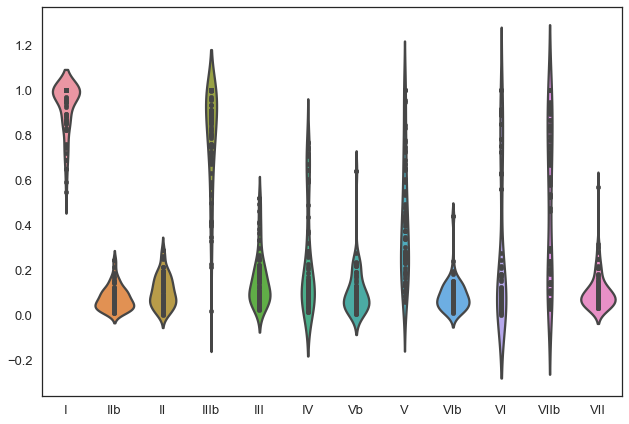

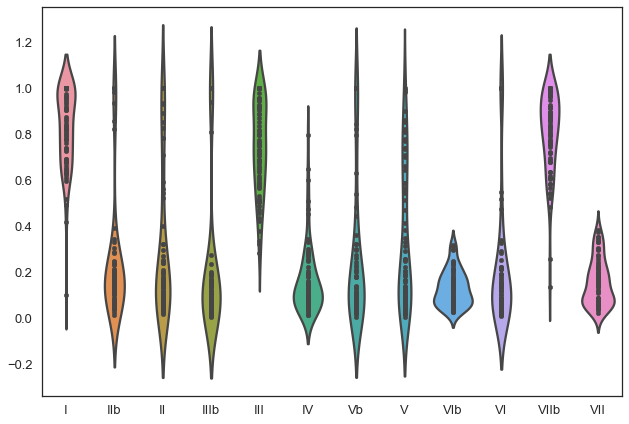

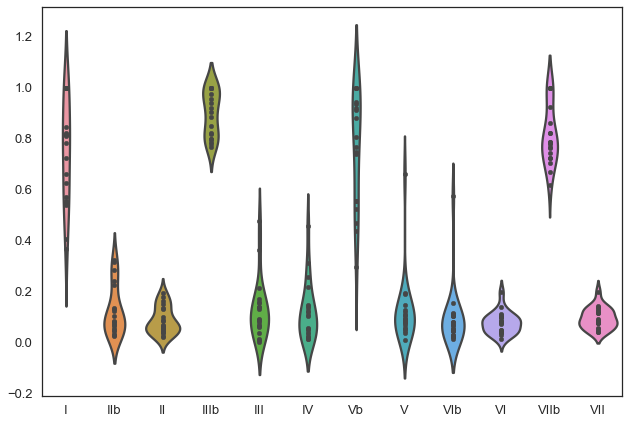

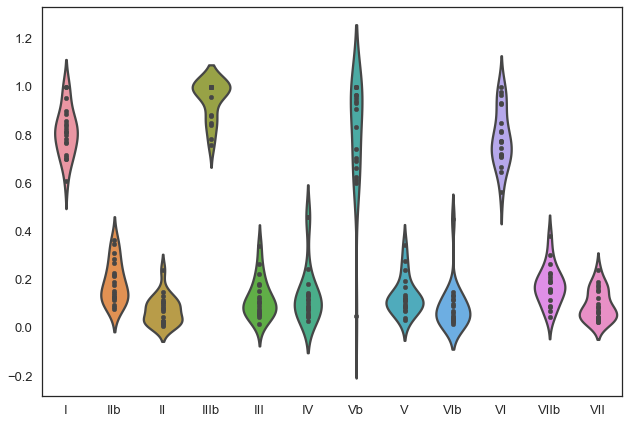

maj BIC:  -2233.74708195  N:  7
min BIC:  -1538.19518334  N:  7
dom BIC:  -1014.24010768  N:  11
hdim7 BIC:  -846.50210811  N:  3
dim BIC:  -699.899002116  N:  4


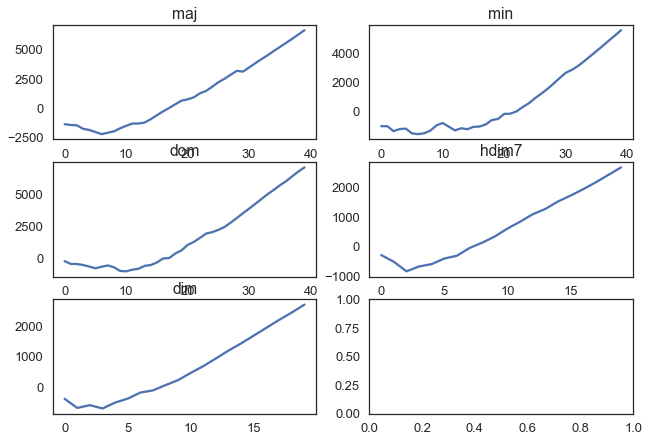

[  7.   7.  11.   3.   4.]
[  98.96141215   99.91341991   99.91341991  100.          100.        ]
[ 91.3369631   80.60496068  74.36176649  67.44706594  65.02117362]


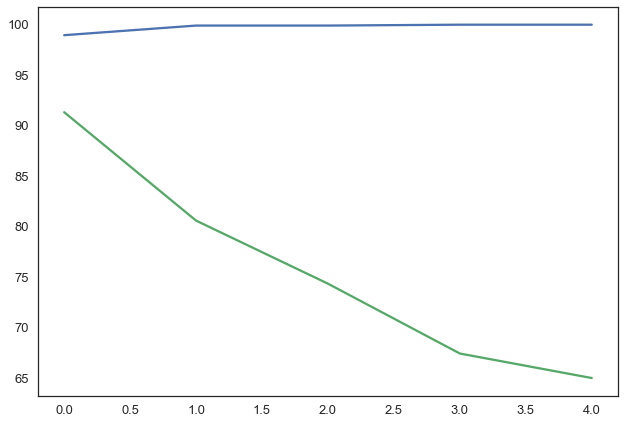

In [59]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

maxChromas = normalize(chromas, norm='max')
violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
score(model, kinds, maxChromas)
n_components = findOptimalNComponentsByBIC(maxChromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, maxChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Log L1

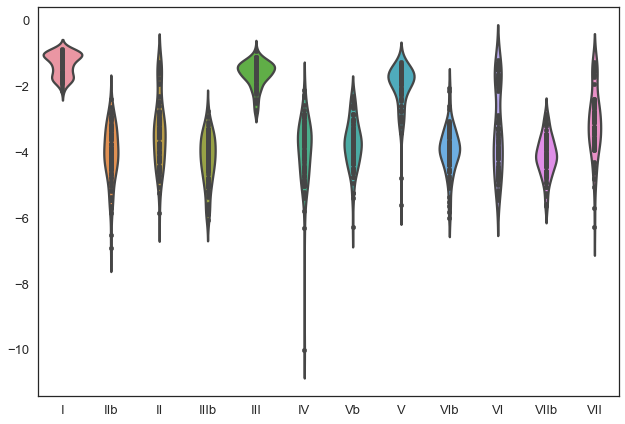

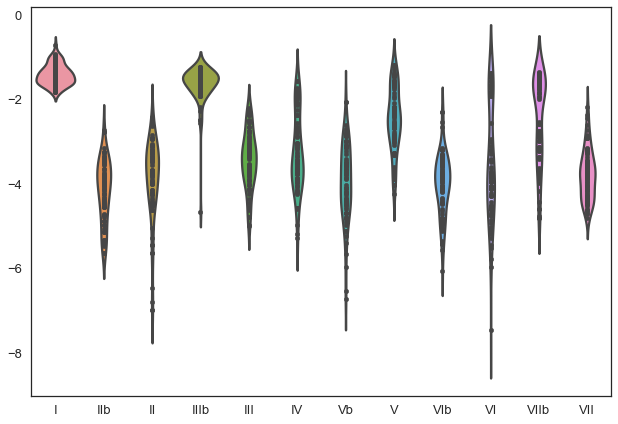

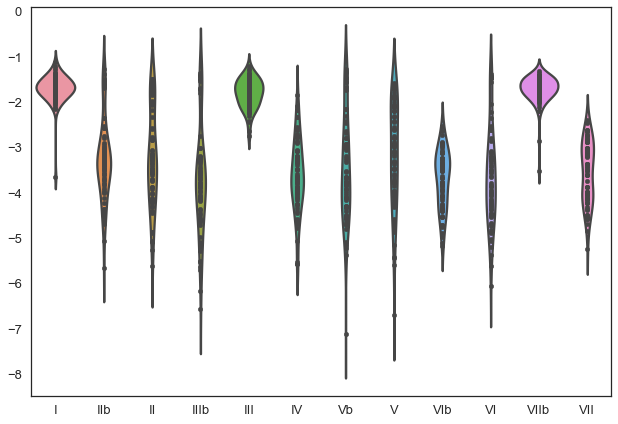

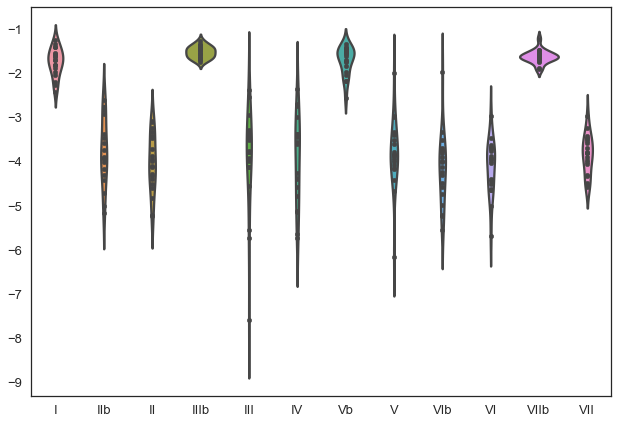

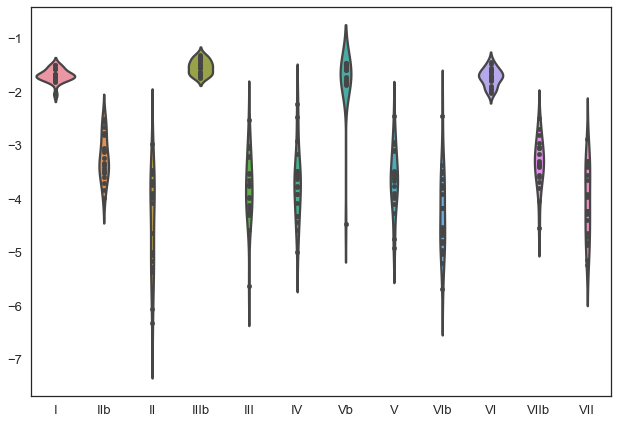

maj BIC:  1681.74923351  N:  21
min BIC:  70.7048813714  N:  12
dom BIC:  817.438349158  N:  14
hdim7 BIC:  -166.436086248  N:  4
dim BIC:  -467.059870341  N:  5


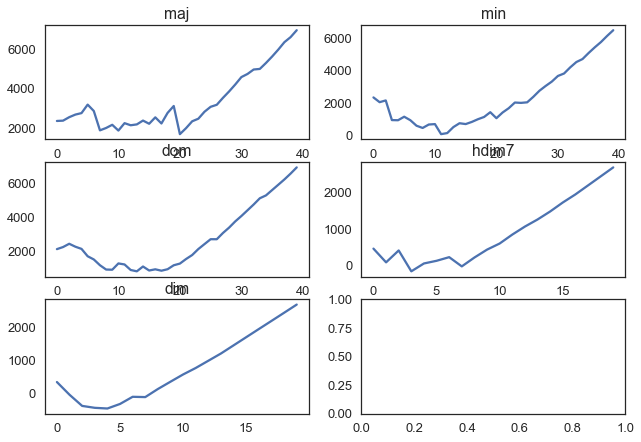

[ 21.  12.  14.   4.   5.]
[  98.87520525   99.65367965   99.82683983  100.          100.        ]
[ 89.96975197  84.42226255  80.61705989  75.42649728  71.59709619]


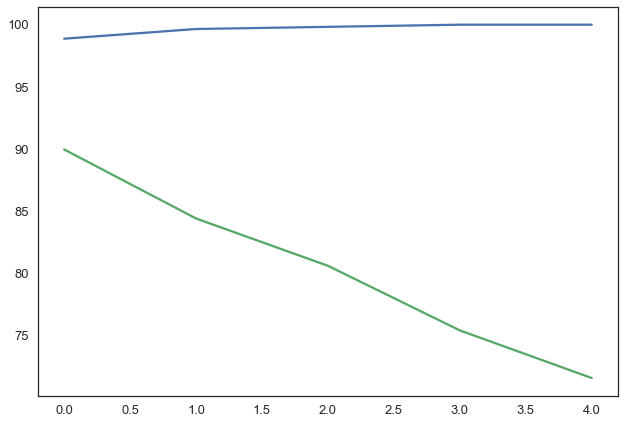

In [60]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l1logChromas = logNormalize(chromas)
violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,3,3,1,1])
score(model, kinds, l1logChromas)
n_components = findOptimalNComponentsByBIC(l1logChromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l1logChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Log-ratio

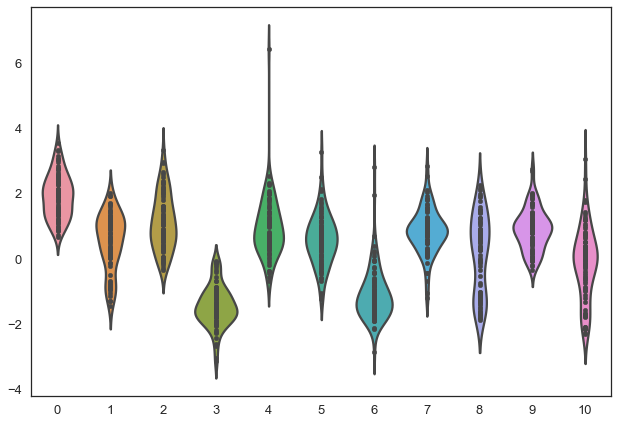

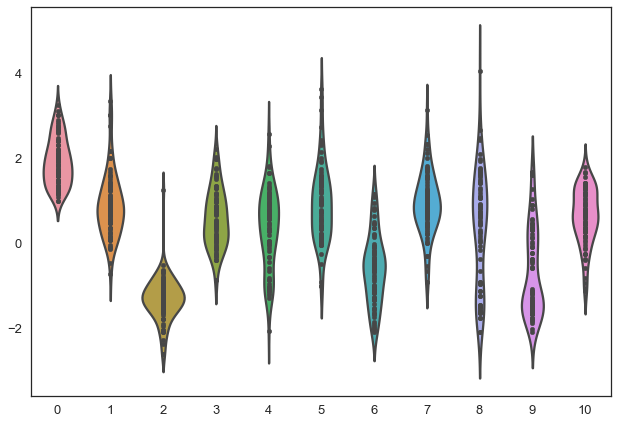

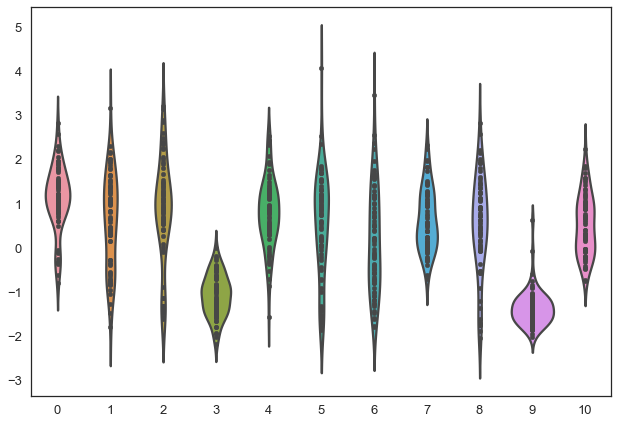

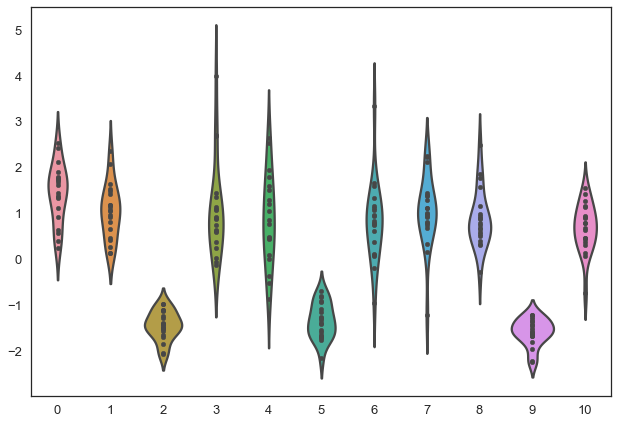

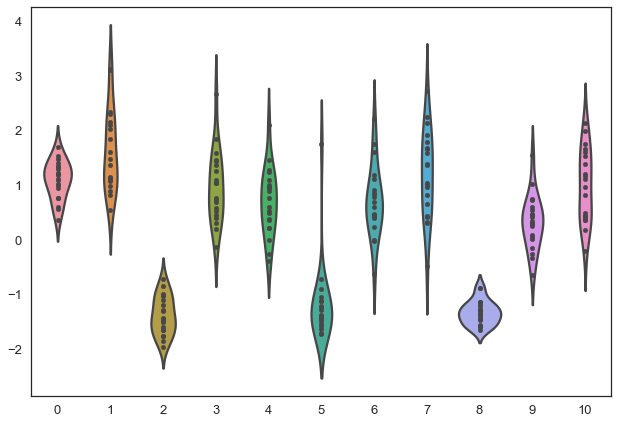

maj BIC:  1478.89849861  N:  18
min BIC:  546.111545529  N:  10
dom BIC:  565.704151707  N:  15
hdim7 BIC:  -410.078165125  N:  6
dim BIC:  -300.886800972  N:  6


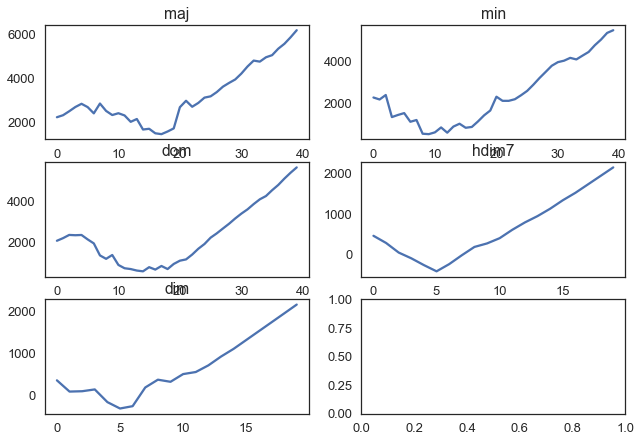

[ 18.  10.  15.   6.   6.]
[  98.87520525   99.74025974   99.91341991  100.          100.        ]
[ 90.30852995  84.42226255  79.23169994  75.06352087  70.55656382]


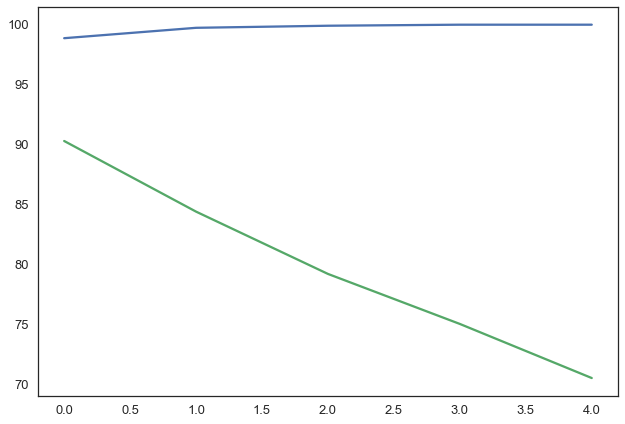

In [61]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

sxChromas = normalizeTo11d(chromas)
violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
score(model, kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,3,3,1,1])
score(model, kinds, sxChromas)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components

trains, tests = trainTestSymmetricalModels(kinds, sxChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()